# Preliminary Sizing
### EAE 130A

The following code outlines how we performed our preliminary sizing calculations. It is derived from the preliminary sizing tutorial.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines # pip install matplotlib-label-lines


Intro & Equation explanation

0.013
0.026798498071700236


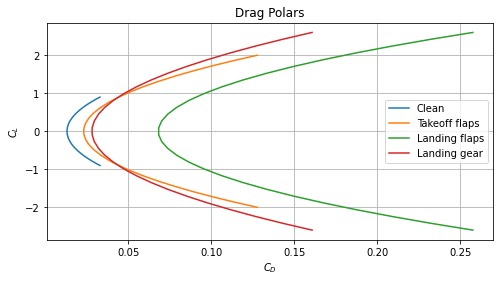

In [2]:
## Drag Polar Estimate
w_to = 57006    #lbs, takeoff weight
Wl_Wto = 0.9748901969341981  # max landing weight fraction
c_f = 0.0026    #skin friction coefficient, Raymer 12.3
c_l = 0.75       ##lift coefficient
"""
c = -0.0866     #Table 3.5 Roskam
d = 0.8099      #Table 3.5 Roskam
s_wet = (10**c)*(w_to**d)
print(s_wet)
rho = 0.0023769        #slug/ft3
c_lmax = 1.9
c_lcruise = 0.5
v_stall = 590.733*np.sqrt(c_lcruise/c_lmax)         #stall speed, ft/s
ws = 0.5*rho*(v_stall**2)*c_l #wingloading, Martins Eq 4.2  #lb/sqft
print(ws)   
s_ref = w_to/ws   #sq.ft, from tutorial
print(s_ref)  
""" 


s_ratio = 5     
c_do = c_f*(s_ratio)
print(c_do)
delta_cdo = [0, 0.010, 0.055, 0.015] # [clean, TO flaps, L flaps, landing gear down]
e_v = 0.80
AR = 16.22       # aspect ratio, from openVSP model
c_d = c_do + ((c_l**2)/((np.pi)*e_v*AR))
print(c_d)
e_v = [0.80, 0.75, 0.70, 1] ## span efficiency factor, array

# Adjust C_Lmax for each flight configuration
cL_clean = np.linspace(-0.9,0.9,30)
cL_takeoff = np.linspace(-2,2,30)
cL_landing = np.linspace(-2.6,2.6,30)
clean = (c_do + delta_cdo[0]) + ((cL_clean**2)/((np.pi)*e_v[0]*AR))
takeoff = (c_do + delta_cdo[1]) + ((cL_takeoff**2)/((np.pi)*e_v[1]*AR))
landing_flaps = (c_do + delta_cdo[2]) + ((cL_landing**2)/((np.pi)*e_v[2]*AR))
landing_gear = (c_do + delta_cdo[3]) + ((cL_landing**2)/((np.pi)*e_v[3]*AR))

plt.figure(figsize=(8,4))
plt.title('Drag Polars')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.plot(clean, cL_clean, label='Clean', linestyle='-')
plt.plot(takeoff, cL_takeoff, label='Takeoff flaps', linestyle='-')
plt.plot(landing_flaps, cL_landing, label='Landing flaps', linestyle='-')
plt.plot(landing_gear, cL_landing, label='Landing gear', linestyle='-')
plt.legend(loc='best')
plt.grid()
plt.savefig('A3fig/DragPolar.svg')
plt.show()


NameError: name 'tw_tofl' is not defined

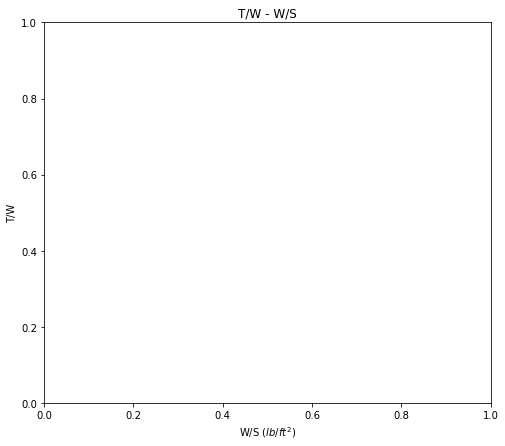

In [3]:
## Constraint Diagram
# useful definitions
N = 100
ws = np.linspace(0.01,170,N)
tw = np.linspace(0,.5,N)
wp = np.linspace(0,30,N)

## Takeoff Field Length
# Assumption: BFL = 4500 from FAR 25 TO Requirements (35 ft obstacle)
CL_max_TO = 2.1 # (Roskam)
BFL = 4500 # ft, requirement
TOP_25 = BFL/37.5
rho_SLp18F = 0.0024428 # slug/ft3, density at ISA + 18F
rho_p18F_5kft = 0.002107 # slug/ft3, density at ISA + 18F
rho_SL = 0.0025332 # slug/ft3, density at ISA
#tw_tofl = ws/((rho_SLp18F/rho_SL)*CL_max_TO*TOP_25) 
#wp_tofl = 1/(0.3467*tw_tofl)

#tw_tofl_5kft = ws/((rho_p18F_5kft/rho_SL)*CL_max_TO*TOP_25) 
#wp_tofl_5kft = 1/(0.3467*tw_tofl_5kft)

# # military mod
s_TOG = BFL*0.6
k1=0.0376
k2=5.75*(20)**(-1/3)
muG=0.025
wp_tofl = k2/((k1*ws/rho_SLp18F/s_TOG+0.72*(c_do + delta_cdo[1]))/CL_max_TO+muG)
wp_tofl_5kft = k2/((k1*ws/rho_p18F_5kft/s_TOG+0.72*(c_do + delta_cdo[1]))/CL_max_TO+muG)
#ws_tofl = s_TOG*rho_SLp18F*(CL_max_TO*(k2/wp-muG)-0.72*CD_0_TO)/k1
#ws_tofl_5kft = s_TOG*rho_p18F_5kft*(CL_max_TO*(k2/wp-muG)-0.72*CD_0_TO)/k1
#s_land = bfl * 0.6

# rho_tot = 0.95  #given during tutorial
# c_lto = 2.1
# tw_tofl = ws/((rho_tot)*c_lto*top)

## Climb Segments
eta_p_climb = 0.75
V_a = 141*1.68780986 # ft/s approach speed, requirement
V_so = V_a/1.3 

def tw_climb(n_engines,n_engines_max,k_s,e_v,CL_max,CD_0,G,N):
    return ((n_engines_max/n_engines)*((((k_s**2)/CL_max)*(CD_0))+(CL_max/((k_s**2)*np.pi*e_v*AR))+G))*np.ones(N)

CL_max_L = 3.3
# TO climb
n_engines_max = 2
n_engines = 1
k_s_TO = 1.2
G_TO = 0.012
e_TO = 0.75    
c_lmax_TO = 2.1
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_TO = c_do 
tw_climb_TO = tw_climb(n_engines,n_engines_max,k_s_TO,e_TO,c_lmax_TO,CD_0_TO,G_TO,N)
wp_climb_TO = 550*eta_p_climb/(tw_climb_TO*V_so*k_s_TO)

# Transition climb
n_engines_max = 2
n_engines = 1
k_s_TC = 1.15
G_TC = 0
e_TC = 0.75    
c_lmax_TC = 2.1
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_TC = c_do + delta_cdo[1] + delta_cdo[3]
tw_climb_TC = tw_climb(n_engines,n_engines_max,k_s_TC,e_TC,c_lmax_TC,CD_0_TC,G_TC,N)
wp_climb_TC = 550*eta_p_climb/(tw_climb_TC*V_so*k_s_TC)

# Second Segment Climb
n_engines_max = 2
n_engines = 1
k_s_SSC = 1.2
G_SSC = 0.024
e_SSC = 0.75    
c_lmax_SSC = 2.1
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_SSC = c_do + delta_cdo[1] 
tw_climb_SSC = tw_climb(n_engines,n_engines_max,k_s_SSC,e_SSC,c_lmax_SSC,CD_0_SSC,G_SSC,N)
wp_climb_SSC = 550*eta_p_climb/(tw_climb_SSC*V_so*k_s_SSC)

# En Route Climb
n_engines_max = 2
n_engines = 1
k_s_ERC = 1.25
G_ERC = 0.012
e_ERC = 0.75
c_lmax_ERC = 1.9
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_ERC = c_do 
tw_climb_ERC = tw_climb(n_engines,n_engines_max,k_s_ERC,e_ERC,c_lmax_ERC,CD_0_ERC,G_ERC,N)
wp_climb_ERC = 550*eta_p_climb/(tw_climb_ERC*V_so*k_s_ERC)

# Balked Landing Climb AEO
n_engines_max = 2
n_engines = 2
k_s_BLC_AEO = 1.3
G_BLC = 0.032
e_BLC = 0.75
c_lmax_BLC = 3.3
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_BLC = c_do + delta_cdo[2] + delta_cdo[3]
tw_climb_BLC_AEO = tw_climb(n_engines,n_engines_max,k_s_BLC_AEO,e_BLC,c_lmax_BLC,CD_0_BLC,G_BLC,N)*Wl_Wto
wp_climb_BLC_AEO = 550*eta_p_climb/(tw_climb_BLC_AEO*V_so*k_s_BLC_AEO)

# Balked Landing Climb OEI  
n_engines_max = 2
n_engines = 1
k_s_BLC_OEI = 1.5
G_BLC = 0.021
e_BLC = 0.75
c_lmax_BLC = 3.3*0.85
V_so = np.sqrt((2*ws) / (rho_SL * CL_max_L))
CD_0_BLC = c_do +  (delta_cdo[1] +delta_cdo[2])/2 + delta_cdo[3]
tw_climb_BLC_OEI = tw_climb(n_engines,n_engines_max,k_s_BLC_OEI,e_BLC,c_lmax_BLC,CD_0_BLC,G_BLC,N)*Wl_Wto
wp_climb_BLC_OEI = 550*eta_p_climb/(tw_climb_BLC_OEI*V_so*k_s_BLC_OEI)

## Cruise
# Asssumptions: 
# 28kft cruise
# constant speed prop (Gudmundsson)
eta_p_max = 0.85 # prop eff at cruise
rho_28kft = 10.66e-4 # slug/ft3, air density at cruise (28kft)
V_min = 275*1.68780986 # ft/s, 275 kts requirement
V_target = 350*1.68780986 # ft/s, 350 kts target
q_min = 0.5*rho_28kft*V_min**2 # psf, dyn pressure at cruise requirement
q_target = 0.5*rho_28kft*V_target**2 # psf, dyn pressure at cruise target
# print(q_min,q_target)
tw_cruise_min = ((q_min*c_do)/ws) + ws*(1/(q_min*(np.pi)*AR*e_v[0])) # tw at cruise requirement
tw_cruise_target = ((q_target*c_do)/ws) + ws*(1/(q_target*(np.pi)*AR*e_v[0])) # tw at cruise target 

wp_cruise_min = 1/tw_cruise_min/(V_min/(eta_p_max*550)) # wp at cruise requirement 
wp_cruise_target = 1/tw_cruise_target/(V_target/(eta_p_max*550)) # wp at cruise target

## Maneuver
# Assumtions:
# 28kft altitude
# Indefinite turn at constant speed and altitude
n = 2.5 # Load factor 
V_maneuver = np.sqrt(n)*V_so
q_maneuver = q_target*(V_maneuver**2/V_target**2)
tw_maneuver = ((q_maneuver * c_do) / ws) + (ws * ((4 * n**2) / (q_maneuver * np.pi * AR * e_v[0])))
wp_maneuver = 550 / (tw_maneuver * (V_maneuver / eta_p_max))

## Ceiling
k = 1 / (np.pi * AR * e_v[0])
tw_ceil = (2 * np.sqrt(k * c_do)) * np.ones(N)
wp_ceil = 550 / (tw_ceil * (V_target / eta_p_max))

## Approach Speed (in terms of stall speed)
CL_max_L = 3.3 # (Roskam)
V_a = 141*1.68780986 # ft/s approach speed, requirement
V_so = V_a/1.3
ws_approach_SLp18 = 1/2*rho_SLp18F*V_so**2*CL_max_L*np.ones(N)/Wl_Wto 
ws_approach_p18_5kft = 1/2*rho_p18F_5kft*V_so**2*CL_max_L*np.ones(N)/Wl_Wto

## Landing Field Length
s_a = 1000 # FAR 25, Martins
s_FL = 4500 # ft, field length requirement
s_L = s_FL*0.6

ws_landing_SLp18=(((rho_SLp18F/rho_SL)*CL_max_L)*(s_L - s_a))/80*np.ones(N)/Wl_Wto
ws_landing_p18_5kft=(((rho_p18F_5kft/rho_SL)*CL_max_L)*(s_L - s_a))/80*np.ones(N)/Wl_Wto


# plotting TW
plt.figure(figsize=(8,7))
plt.title('T/W - W/S')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("T/W")
plt.plot(ws, tw_tofl, label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, tw_tofl_5kft, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, tw_climb_TO, label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, tw_climb_TC, label='Transition climb OEI', linestyle='-')
plt.plot(ws, tw_climb_SSC, label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, tw_climb_ERC, label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, tw_climb_BLC_AEO, label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, tw_climb_BLC_OEI, label='Balked Landing Climb OEI', linestyle='-')


plt.plot(ws, tw_cruise_min, label='28kft Cruise @ 275kts', linestyle='-')
plt.plot(ws, tw_cruise_target, label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws, tw_ceil, label='Ceiling', linestyle='-')
# plt.plot(ws, tw_maneuver, label='2.5g Maneuver', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/7):], np.flip(tw)[int(N/7):], label='Approach @ 141kts, ISA+18F', linestyle='-')
plt.plot(ws_approach_p18_5kft[int(N/6):], np.flip(tw)[int(N/6):], label='Approach @ 141kts, ISA+18F, 5kft', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/7):], np.flip(tw)[int(N/7):], label='Landing field length, ISA+18F', linestyle='-')
plt.plot(ws_landing_p18_5kft[int(N/6):], np.flip(tw)[int(N/6):], label='Landing field length, ISA+18F, 5kft', linestyle='-')

plt.ylim(0, 0.5), plt.xlim(0, 170)
plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,140))
plt.savefig('A3fig/TW_Plot.svg')
# plt.legend(loc='best')
# plt.show()

# plotting WP
plt.figure(figsize=(8,7))

plt.title('W/P - W/S')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("W/P $(lbm/bhp)$")

plt.plot(ws, wp_tofl, label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, wp_tofl_5kft, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws_tofl, wp, label='Takeoff field length, ISA+18F', linestyle='-')
# plt.plot(ws_tofl_5kft, wp, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, wp_climb_TO, label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, wp_climb_TC, label='Transition climb OEI', linestyle='-')
plt.plot(ws, wp_climb_SSC, label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, wp_climb_ERC, label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, wp_climb_BLC_AEO, label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, wp_climb_BLC_OEI, label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, wp_ceil, label='Ceiling', linestyle='-')
# plt.plot(ws, wp_maneuver, label='2.5g Maneuver', linestyle='-')

plt.plot(ws, wp_cruise_min, label='28kft Cruise @ 275kts', linestyle='-')
plt.plot(ws, wp_cruise_target, label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/7):], np.flip(wp)[int(N/7):], label='Approach @ 141kts, ISA+18F', linestyle='-')
plt.plot(ws_approach_p18_5kft[int(N/6):], np.flip(wp)[int(N/6):], label='Approach @ 141kts, ISA+18F, 5kft', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/7):], np.flip(wp)[int(N/7):], label='Landing field length, ISA+18F', linestyle='-')
plt.plot(ws_landing_p18_5kft[int(N/6):], np.flip(wp)[int(N/6):], label='Landing field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws, tw_climb, label='Takeoff climb', linestyle='-')

plt.ylim(0, 30), plt.xlim(0, 170)
# plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,150))
plt.scatter(ws_landing_SLp18[0],wp_climb_BLC_OEI[0], zorder=5,color='red',label='Design Point')


plt.fill_between(
        x= ws, 
        y1= np.minimum(wp_cruise_target,wp_tofl_5kft),
        where= (0 < ws)&(ws <= ws_landing_p18_5kft[0]),
        color= "b",
        alpha= 0.2)

plt.savefig('A3fig/WP_Plot.svg')
plt.show()

In [ ]:
print('Sized Wing Area: {:.3f}ft2, Sized Power: {:.3f}bhp'.format(w_to/ws_landing_SLp18[0], w_to/wp_climb_BLC_OEI[0]))

print('Sized Wing Area: {:.3f}ft2, Sized Power: {:.3f}bhp'.format(ws_landing_SLp18[0], wp_climb_BLC_OEI[0]))

Sized Wing Area: 821.836ft2, Sized Power: 61.400bhp
Sized Wing Area: 69.364ft2, Sized Power: 928.438bhp


C:\Users\reidl\AppData\Local\Temp\ipykernel_19296\636914854.py:61: RuntimeWarning: divide by zero encountered in reciprocal
  WPvector = PTvector**-1
C:\Users\reidl\AppData\Local\Temp\ipykernel_19296\636914854.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  P_p = [0,0,0,0,0,0,0,0,0,1/y] # bhp/lbm
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 11 in `xvals` is outside the range of its associated line (xmin=138.5526103014556, xmax=138.5526103014556, xval=112.5). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 12 in `xvals` is outside the range of its associated line (xmin=119.50644748041874, xmax=119.50644748041874, xval=121.875). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 13 in `xvals` is outside

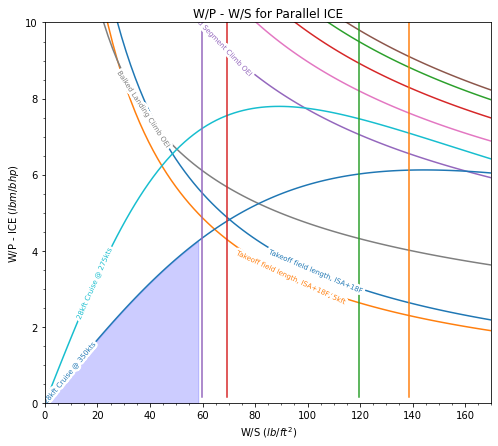

c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 9 in `xvals` is outside the range of its associated line (xmin=138.5526103014556, xmax=138.5526103014556, xval=107.14285714285714). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 10 in `xvals` is outside the range of its associated line (xmin=119.50644748041874, xmax=119.50644748041874, xval=117.85714285714285). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 11 in `xvals` is outside the range of its associated line (xmin=69.36423531558572, xmax=69.36423531558572, xval=128.57142857142856). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 12 in `xvals` is outside the rang

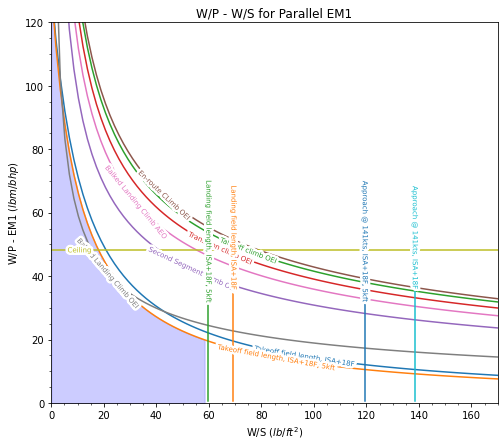

c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 9 in `xvals` is outside the range of its associated line (xmin=138.5526103014556, xmax=138.5526103014556, xval=107.14285714285714). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 10 in `xvals` is outside the range of its associated line (xmin=119.50644748041874, xmax=119.50644748041874, xval=117.85714285714285). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 11 in `xvals` is outside the range of its associated line (xmin=69.36423531558572, xmax=69.36423531558572, xval=128.57142857142856). Clipping it into the allowed range.
  warnings.warn(
c:\Users\reidl\anaconda3\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 12 in `xvals` is outside the rang

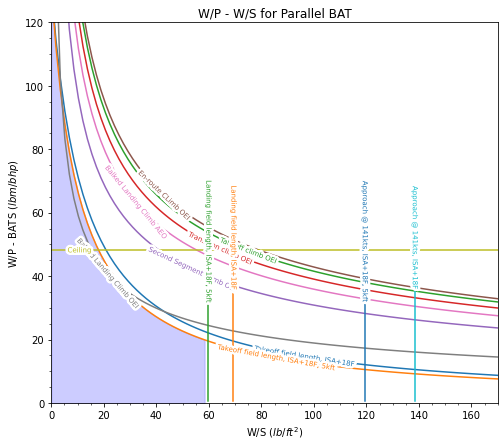

In [ ]:
# format = [GT,GB,P1,EM1,PM,EM2,P2]
# value justification
# P1,P2 = 0.85 (Constant Speed, Gudmundsson)
# the rest = deVries
eta = [.3,.96,.9,.9,.99,.9,.9]
# [0,0,0,0,0,0,0,0,0,0]

PRatio = 0.5 # shaft power ratio
ERatio = 0.02 # supplied power ratio
# Constraints
'''
wp_tofl
wp_tofl_5kft
wp_climb_TO
wp_climb_TC
wp_climb_SSC
wp_climb_ERC
wp_climb_BLC_AEO
wp_climb_BLC_OEI
wp_ceil
wp_cruise_min
wp_cruise_target
wp_approach_SLp18
wp_approach_p18_5kft
wp_landing_SLp18
wp_landing_p18_5kft

'''
# Serial configuration
Serial_Pratios = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
Serial_Eratios = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0,0,0.02,0.02,0.02,0.02,0.02]
# Parallel Configuration
Parallel_Pratios = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Parallel_Eratios = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0,0,0.2,0.2,0.2,0.2,0.2]
# Serial Parallel Configuration
SP_Pratios = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
SP_Eratios = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0,0,0.02,0.02,0.02,0.02,0.02]

powerLoadings = [wp_tofl, wp_tofl_5kft, wp_climb_TO, wp_climb_TC, wp_climb_SSC, wp_climb_ERC, wp_climb_BLC_AEO, wp_climb_BLC_OEI, wp_ceil, wp_cruise_min, wp_cruise_target, np.flip(wp)[int(N/7):], np.flip(wp)[int(N/6):], np.flip(wp)[int(N/7):], np.flip(wp)[int(N/6):]]
newLoadings = [0] * len(powerLoadings)
for x in range(0,15):
    constraint = powerLoadings[x]
    loadVals = [0] * (len(constraint))
    ERatio = Parallel_Eratios[x]
    PRatio = Parallel_Pratios[x]
    for ind, y in enumerate(constraint):
        PTmatrix = np.array([[-eta[0],1,0,0,0,0,0,0,0,0],
                                [0,-eta[1],1,1,0,0,0,0,0,0],
                                [0,0,0,-eta[2],0,0,0,0,1,0],
                                [0,0,-eta[3],0,1,0,0,0,0,0],
                                [0,0,0,0,-eta[4],-eta[4],1,0,0,0],
                                [0,0,0,0,0,0,-eta[5],1,0,0],
                                [0,0,0,0,0,0,0,-eta[6],0,1],
                                [ERatio,0,0,0,0,ERatio-1,0,0,0,0],
                                [0,0,0,PRatio,0,0,0,PRatio-1,0,0],
                                [0,0,0,0,0,0,0,0,1,1]])
        
        
        P_p = [0,0,0,0,0,0,0,0,0,1/y] # bhp/lbm
        PTvector = np.linalg.solve(PTmatrix,P_p)
        WPvector = PTvector**-1
        setVals = [WPvector[0], WPvector[4], WPvector[5]]
        loadVals[ind] = setVals

    newLoadings[x] = loadVals

ices = [0] * 100
ems = [0] * 100 
bats = [0] * 100 
for x in range(0,15):
    t = newLoadings[x][:][:]
    ivals = [0] * len(t)
    evals = [0] * len(t)
    bvals = [0] * len(t)
    for z in range(0, len(t)):
        ivals[z] = abs(t[z][0])
        evals[z] = abs(t[z][1])
        bvals[z] = abs(t[z][2])
    
    ices[x] = ivals
    ems[x] = evals
    bats[x] = bvals

plt.figure(figsize=(8,7))

plt.title('W/P - W/S for Parallel ICE')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("W/P - ICE $(lbm/bhp)$")

plt.plot(ws, ices[0], label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, ices[1], label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws_tofl, wp, label='Takeoff field length, ISA+18F', linestyle='-')
# plt.plot(ws_tofl_5kft, wp, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, ices[2], label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, ices[3], label='Transition climb OEI', linestyle='-')
plt.plot(ws, ices[4], label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, ices[5], label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, ices[6], label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, ices[7], label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, ices[8], label='Ceiling', linestyle='-')
# plt.plot(ws, wp_maneuver, label='2.5g Maneuver', linestyle='-')

plt.plot(ws, ices[9], label='28kft Cruise @ 275kts', linestyle='-')
plt.plot(ws, ices[10], label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/7):], ices[11], label='Approach @ 141kts, ISA+18F', linestyle='-')
plt.plot(ws_approach_p18_5kft[int(N/6):], ices[12], label='Approach @ 141kts, ISA+18F, 5kft', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/7):], ices[13], label='Landing field length, ISA+18F', linestyle='-')
plt.plot(ws_landing_p18_5kft[int(N/6):], ices[14], label='Landing field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws, tw_climb, label='Takeoff climb', linestyle='-')

plt.ylim(0, 10), plt.xlim(0, 170)
# plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,150))
#plt.scatter(ws_landing_SLp18[0],wp_climb_BLC_OEI[0], zorder=5,color='red',label='Design Point')


plt.fill_between(
        x= ws, 
        y1= np.minimum(ices[10],ices[1]),
        where= (0 < ws)&(ws <= ws_landing_p18_5kft[0]),
        color= "b",
        alpha= 0.2)

#plt.savefig('A3fig/WP_Plot.svg')
plt.show()





plt.figure(figsize=(8,7))

plt.title('W/P - W/S for Parallel EM1')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("W/P - EM1 $(lbm/bhp)$")

plt.plot(ws, ems[0], label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, ems[1], label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws_tofl, wp, label='Takeoff field length, ISA+18F', linestyle='-')
# plt.plot(ws_tofl_5kft, wp, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, ems[2], label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, ems[3], label='Transition climb OEI', linestyle='-')
plt.plot(ws, ems[4], label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, ems[5], label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, ems[6], label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, ems[7], label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, ems[8], label='Ceiling', linestyle='-')
# plt.plot(ws, wp_maneuver, label='2.5g Maneuver', linestyle='-')

#plt.plot(ws, ems[9], label='28kft Cruise @ 275kts', linestyle='-')
#plt.plot(ws, ems[10], label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/7):], ems[11], label='Approach @ 141kts, ISA+18F', linestyle='-')
plt.plot(ws_approach_p18_5kft[int(N/6):], ems[12], label='Approach @ 141kts, ISA+18F, 5kft', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/7):], ems[13], label='Landing field length, ISA+18F', linestyle='-')
plt.plot(ws_landing_p18_5kft[int(N/6):], ems[14], label='Landing field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws, tw_climb, label='Takeoff climb', linestyle='-')

plt.xlim(0, 170)
plt.ylim(0, 120)
# plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,150))
#plt.scatter(ws_landing_SLp18[0],wp_climb_BLC_OEI[0], zorder=5,color='red',label='Design Point')


plt.fill_between(
        x= ws, 
        y1= np.minimum(ems[10],ems[1]),
        where= (0 < ws)&(ws <= ws_landing_p18_5kft[0]),
        color= "b",
        alpha= 0.2)

#plt.savefig('A3fig/WP_Plot.svg')

plt.show()




plt.figure(figsize=(8,7))

plt.title('W/P - W/S for Parallel BAT')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("W/P - BATS $(lbm/bhp)$")

plt.plot(ws, bats[0], label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, bats[1], label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws_tofl, wp, label='Takeoff field length, ISA+18F', linestyle='-')
# plt.plot(ws_tofl_5kft, wp, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, bats[2], label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, bats[3], label='Transition climb OEI', linestyle='-')
plt.plot(ws, bats[4], label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, bats[5], label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, bats[6], label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, bats[7], label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, bats[8], label='Ceiling', linestyle='-')
# plt.plot(ws, wp_maneuver, label='2.5g Maneuver', linestyle='-')

#plt.plot(ws, bats[9], label='28kft Cruise @ 275kts', linestyle='-')
#plt.plot(ws, bats[10], label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/7):], bats[11], label='Approach @ 141kts, ISA+18F', linestyle='-')
plt.plot(ws_approach_p18_5kft[int(N/6):], bats[12], label='Approach @ 141kts, ISA+18F, 5kft', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/7):], bats[13], label='Landing field length, ISA+18F', linestyle='-')
plt.plot(ws_landing_p18_5kft[int(N/6):], bats[14], label='Landing field length, ISA+18F, 5kft', linestyle='-')

# plt.plot(ws, tw_climb, label='Takeoff climb', linestyle='-')

plt.xlim(0, 170)
plt.ylim(0, 120)
# plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,150))
#plt.scatter(ws_landing_SLp18[0],wp_climb_BLC_OEI[0], zorder=5,color='red',label='Design Point')


plt.fill_between(
        x= ws, 
        y1= np.minimum(bats[10],bats[1]),
        where= (0 < ws)&(ws <= ws_landing_p18_5kft[0]),
        color= "b",
        alpha= 0.2)

#plt.savefig('A3fig/WP_Plot.svg')

plt.show()

